Dataset link: https://universe.roboflow.com/ai-widetech-2/acne-detection-hrhbi 

In [ ]:
# Import necessary libraries for data processing, visualization, and modeling.
import os # Provides functions for interacting with the operating system.
import pandas as pd # Used for data manipulation and analysis.
import numpy as np # Provides support for numerical operations with arrays.
import matplotlib.pyplot as plt # Used for creating visualizations.
import cv2 # OpenCV library for computer vision tasks.
from tqdm.notebook import tqdm # Provides progress bars for iterative processes.

import tensorflow as tf # TensorFlow library for deep learning.
from tensorflow.keras import * # Imports all modules and classes from Keras.
from tensorflow.keras.optimizers import AdamW # Imports the AdamW optimizer.
from tensorflow.keras.callbacks import * # Imports all callback functions.
import keras_cv # Imports the keras_cv library.

# Define batch size for training.
BATCH_SIZE = 16
# Set AUTO to tf.data.AUTOTUNE for automatic performance optimization.
AUTO = tf.data.AUTOTUNE

2024-02-04 00:15:19.233384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 00:15:19.233548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 00:15:19.415886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


# <span style="color:#e74c3c;"> </span> Preprocessing

### Data Preparation Stage

This section focuses on preparing the data for training the YOLOv8 model. It involves:

1. **Creating File Paths:** The `creating_files` function generates lists of image and annotation file paths, which are crucial for loading the dataset.

2. **Parsing Annotations:** The `parse_txt_annot` function reads the annotation files and extracts the bounding box information for each image. This data is essential for training the object detection model.

3. **Data Structure:** The output of `creating_files` is a tuple containing `image_paths`, `classes`, and `bbox`. These elements are stored as `tf.ragged.constant` objects to handle variable-length sequences efficiently.

This data preparation stage ensures that the input data is correctly formatted and organized for the subsequent training process.

In [ ]:
# Cell 3: Function to Parse Annotations

# Define a function to parse annotation files in YOLO format.
def parse_txt_annot(img_path, txt_path):
    """
    Parses annotation files in YOLO format and extracts bounding box information.

    Args:
        img_path (str): Path to the image file.
        txt_path (str): Path to the annotation file.

    Returns:
        tuple: A tuple containing the image path, classes, and bounding boxes.
    """
    img = cv2.imread(img_path) # Read the image using OpenCV.
    w = int(img.shape[0]) # Get the width of the image.
    h = int(img.shape[1]) # Get the height of the image.

    file_label = open(txt_path, "r") # Open the annotation file in read mode.
    lines = file_label.read().split('\n') # Read lines from the file and split them.

    boxes = [] # Initialize an empty list to store bounding boxes.
    classes = [] # Initialize an empty list to store classes.

    if lines[0] == '':
        return img_path, classes, boxes # Return if the file is empty.
    else:
        for i in range(0, int(len(lines))): # Iterate through each line in the file.
            objbud=lines[i].split(' ') # Split the line into elements.
            class_ = int(objbud[0]) # Get the class ID.

            # Extract bounding box coordinates.
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])

            # Calculate bounding box coordinates in pixel values.
            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)

            boxes.append([xmin ,ymin ,xmax ,ymax]) # Append the bounding box to the list.
            classes.append(class_) # Append the class ID to the list.

    return img_path, classes, boxes # Return the image path, classes, and bounding boxes.


# Cell 4: Function to Create File Paths List

# Define a function to create a list of file paths.
def create_paths_list(path):
    """
    Creates a list of file paths from a given directory.

    Args:
        path (str): Path to the directory containing the files.

    Returns:
        list: A list of file paths.
    """
    full_path = [] # Initialize an empty list to store file paths.
    images = sorted(os.listdir(path)) # Get a sorted list of files in the directory.

    for i in images: # Iterate through each file in the directory.
        full_path.append(os.path.join(path, i)) # Append the full path of the file to the list.

    return full_path # Return the list of file paths.

# Define class IDs and mapping for the dataset.
class_ids = ['Acne'] # List of class IDs.
class_mapping = {0: 'Acne'} # Dictionary mapping class IDs to class names.

In [ ]:
# Cell 5: Function to Create Files Dictionary

# Define a function to create a dictionary of files.
def creating_files(img_files_paths, annot_files_paths):
    """
    Creates a dictionary containing image paths, classes, and bounding boxes.

    Args:
        img_files_paths (str): Path to the directory containing image files.
        annot_files_paths (str): Path to the directory containing annotation files.

    Returns:
        tuple: A tuple containing image paths, classes, and bounding boxes as tf.ragged.constant objects.
    """
    img_files = create_paths_list(img_files_paths) # Create a list of image file paths.
    annot_files = create_paths_list(annot_files_paths) # Create a list of annotation file paths.

    image_paths = [] # Initialize an empty list to store image paths.
    bbox = [] # Initialize an empty list to store bounding boxes.
    classes = [] # Initialize an empty list to store classes.

    for i in range(0,len(img_files)): # Iterate through each image file.
        # Parse the annotation file and extract information.
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_) # Append the image path to the list.
        bbox.append(bbox_) # Append the bounding boxes to the list.
        classes.append(classes_) # Append the classes to the list.

    # Convert the lists to tf.ragged.constant objects.
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox # Return the image paths, classes, and bounding boxes.

In [ ]:
# Cell 6: Applying Functions and Creating Datasets

# Apply the functions to create training, validation, and test datasets.
train_img_paths, train_classes, train_bboxes = creating_files('/content/drive/MyDrive/data-2/test/images',
                                                              '/content/drive/MyDrive/data-2/test/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('/content/drive/MyDrive/data-2/valid/images',
                                                             '/content/drive/MyDrive/data-2/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('/content/drive/MyDrive/data-2/test/images',
                                                          '//content/drive/MyDrive/data-2/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

## Dataset Creation and Augmentation Stage

This section deals with creating the training, validation, and test datasets, and applying data augmentation:

1. **Dataset Creation:** `tf.data.Dataset` is used to create datasets from the image paths, classes, and bounding boxes. This provides an efficient way to manage and process the data during training.

2. **Data Augmentation:** The `JitteredResize` layer is used for data augmentation, which helps to improve the model's generalization ability by introducing variations in the input data.

3. **Batching and Prefetching:** The datasets are batched and prefetched to optimize the training process by ensuring that data is readily available for the model.

This stage prepares the datasets in a format suitable for training the YOLOv8 model and incorporates data augmentation to enhance its performance.

In [ ]:
# Cell 7: Image Preprocessing and Dataset Loading

# Define a function for image preprocessing.
def img_preprocessing(img_path):
    """
    Preprocesses an image by reading, decoding, and casting it to float32.

    Args:
        img_path (str): Path to the image file.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    img = tf.io.read_file(img_path) # Read the image file.
    img = tf.image.decode_jpeg(img, channels = 3) # Decode the image as JPEG with 3 channels.
    img = tf.cast(img, tf.float32) # Cast the image to float32.

    return img # Return the preprocessed image.

# Create a JitteredResize layer for data augmentation.
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640), # Target size for resizing.
    scale_factor=(0.8, 1.25), # Scale factor for jittered resizing.
    bounding_box_format="xyxy") # Bounding box format.

# Define a function to load the dataset.
def load_ds(img_paths, classes, bbox):
    """
    Loads the dataset by preprocessing images and creating bounding boxes.

    Args:
        img_paths (tf.Tensor): Tensor of image paths.
        classes (tf.Tensor): Tensor of class labels.
        bbox (tf.Tensor): Tensor of bounding boxes.

    Returns:
        dict: A dictionary containing the image and bounding boxes.
    """
    img = img_preprocessing(img_paths) # Preprocess the image.

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32), # Cast classes to float32.
        "boxes": bbox } # Bounding boxes.

    return {"images": img, "bounding_boxes": bounding_boxes} # Return the image and bounding boxes.

# Define a function to convert a dictionary to a tuple.
def dict_to_tuple(inputs):
    """
    Converts a dictionary to a tuple.

    Args:
        inputs (dict): A dictionary containing the image and bounding boxes.

    Returns:
        tuple: A tuple containing the image and bounding boxes.
    """
    return inputs["images"], inputs["bounding_boxes"] # Return the image and bounding boxes as a tuple.

In [ ]:
# Cell 8: Creating Dataset Loaders and tf.datasets

# Create dataset loaders and tf.datasets for training, validation, and testing.
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO) # Apply the load_ds function to each element.
                 .shuffle(BATCH_SIZE*10) # Shuffle the dataset.
                 .ragged_batch(BATCH_SIZE, drop_remainder = True) # Create batches of data.
                 .map(resizing, num_parallel_calls = AUTO) # Apply the resizing layer.
                 .map(dict_to_tuple, num_parallel_calls = AUTO) # Convert the dictionary to a tuple.
                 .prefetch(AUTO)) # Prefetch data for faster processing.

valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO) # Apply the load_ds function to each element.
                 .ragged_batch(BATCH_SIZE, drop_remainder = True) # Create batches of data.
                 .map(resizing, num_parallel_calls = AUTO) # Apply the resizing layer.
                 .map(dict_to_tuple, num_parallel_calls = AUTO) # Convert the dictionary to a tuple.
                 .prefetch(AUTO)) # Prefetch data for faster processing.

test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO) # Apply the load_ds function to each element.
                .ragged_batch(BATCH_SIZE, drop_remainder = True) # Create batches of data.
                .map(resizing, num_parallel_calls =

In [ ]:
# Cell 9: Function to Visualize Dataset Samples

# Define a function to visualize samples from a dataset.
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    """
    Visualizes samples from a dataset with bounding boxes.

    Args:
        inputs (tf.data.Dataset): The dataset to visualize.
        value_range (tuple): The value range of the images.
        rows (int): The number of rows in the visualization grid.
        cols (int): The number of columns in the visualization grid.
        bounding_box_format (str): The format of the bounding boxes.
    """
    inputs = next(iter(inputs.take(1))) # Get the first batch of data.
    images, bounding_boxes = inputs[0], inputs[1] # Extract images and bounding boxes.

    keras_cv.visualization.plot_bounding_box_gallery(
        images, # Images to visualize.
        value_range=value_range, # Value range of the images.
        rows=rows, # Number of rows in the grid.
        cols=cols, # Number of columns in the grid.
        y_true=bounding_boxes, # Ground truth bounding boxes.
        scale = 6, # Scale factor for the visualization.
        font_scale = 0.8, # Font scale for the labels.
        line_thickness=2, # Line thickness for the bounding boxes.
        dpi = 100, # DPI for the visualization.
        bounding_box_format=bounding_box_format, # Format of the bounding boxes.
        class_mapping=class_mapping, # Mapping of class IDs to class names.
        true_color = (192, 57, 43)) # Color for the ground truth bounding boxes.

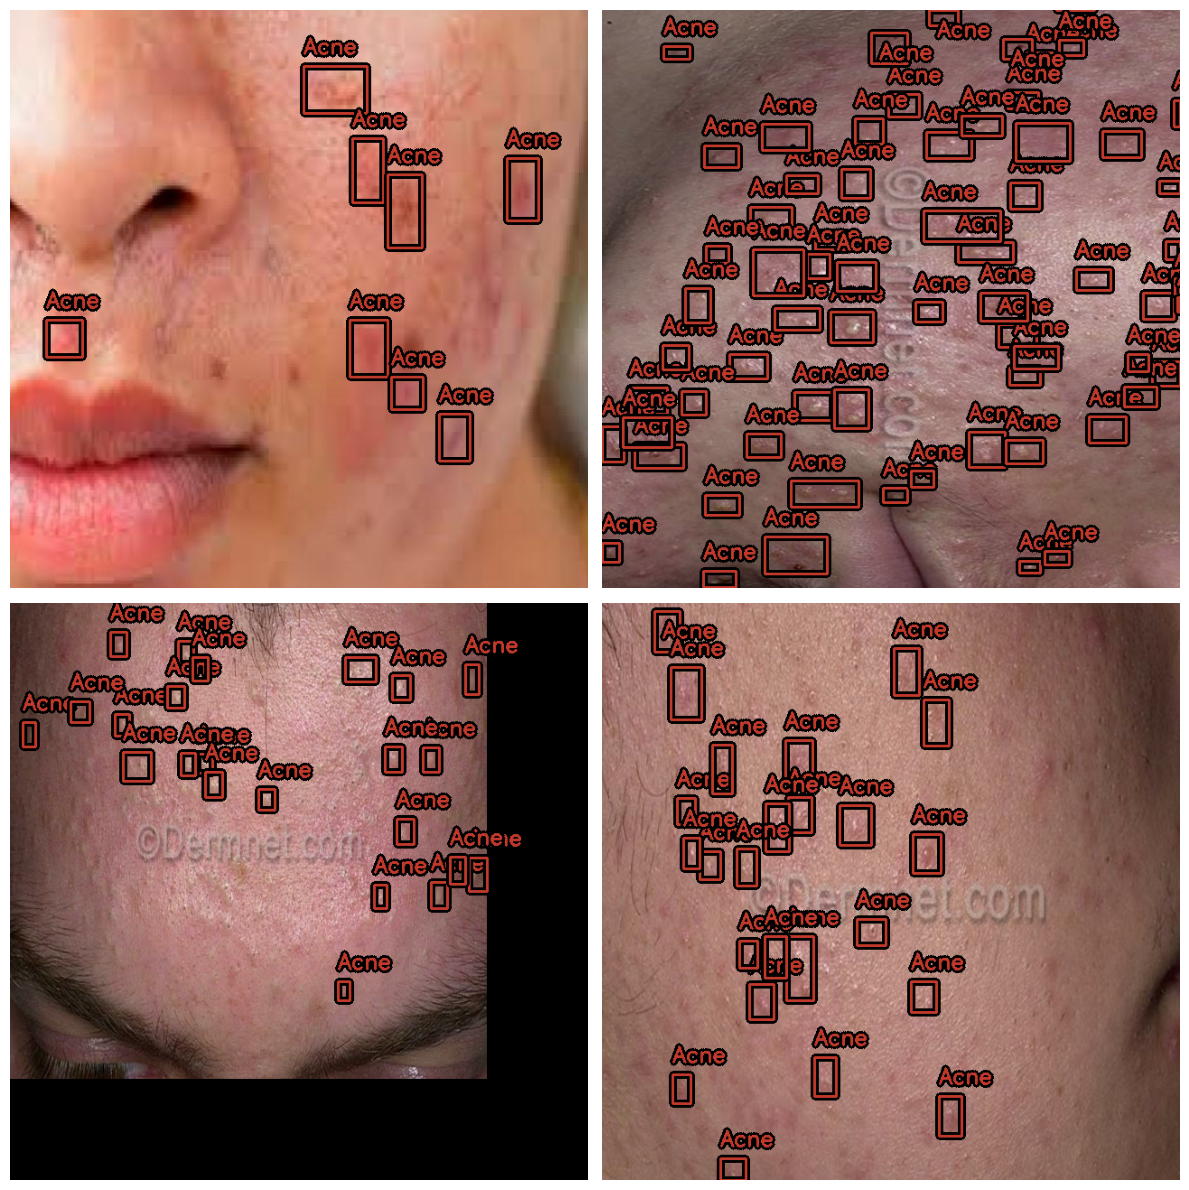

In [8]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

## Model Creation and Compilation Stage

This section focuses on creating the YOLOv8 model and configuring it for training:

1. **Mirrored Strategy:** `tf.distribute.MirroredStrategy` is used to enable distributed training across multiple GPUs, if available. This can significantly speed up the training process.

2. **YOLOv8 Model:** The `keras_cv.models.YOLOV8Detector` class is used to create the YOLOv8 model. The backbone, bounding box format, and other parameters are specified.

3. **Optimizer and Callbacks:** An Adam optimizer is used for training, and callbacks such as `ModelCheckpoint`, `ReduceLROnPlateau`, and `EarlyStopping` are employed to monitor and control the training process.

4. **Compilation:** The model is compiled with the specified optimizer, loss functions, and metrics. This prepares the model for training.

This stage sets up the model, optimizer, and training parameters, ensuring that the model is ready for the training process.

In [ ]:
# Cell 11: Creating Mirrored Strategy

# Create a mirrored strategy for distributed training.
stg = tf.distribute.MirroredStrategy()

In [ ]:
# Cell 12: Creating YOLOv8 Backbone and Model

# Create the YOLOv8 backbone and model within the mirrored strategy scope.
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer.

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)

    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                                  bounding_box_format = "xyxy", backbone = backbone, fpn_depth = 5)

    optimizer = Adam(learning_rate=0.0007, weight_decay=0.0009, global_clipnorm = 10.0)
    my_callbacks = [ModelCheckpoint('/content/yolo_acne_detection.weights.h5', # Changed the filepath to include .weights.h5
                                    monitor = 'val_loss',
                                    save_best_only = True,
                                    save_weights_only = True),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=8, verbose=0, min_delta=0.001),
                    EarlyStopping(monitor='val_loss', patience=20)]

    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_xs_backbone/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_xs_backbone/2' to your Kaggle notebook...


# <span style="color:#e74c3c;"> Training </span> 

In [ ]:
# Cell 13: Training the Model

# Train the YOLOv8 model using the training and validation datasets.
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 20, callbacks = my_callbacks)

Epoch 1/140


I0000 00:00:1707005877.932764      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 139s 483ms/step - loss: 226.7494 - box_loss: 9.1919 - class_loss: 217.5575 - val_loss: 106.1737 - val_box_loss: 6.9576 - val_class_loss: 99.2161 - lr: 7.0000e-04
Epoch 2/140
51/51 [==============================] - 20s 379ms/step - loss: 89.0917 - box_loss: 7.6036 - class_loss: 81.4881 - val_loss: 64.7626 - val_box_loss: 7.5852 - val_class_loss: 57.1774 - lr: 7.0000e-04
Epoch 3/140
51/51 [==============================] - 20s 374ms/step - loss: 49.4744 - box_loss: 7.4445 - class_loss: 42.0299 - val_loss: 41.4162 - val_box_loss: 7.4879 - val_class_loss: 33.9283 - lr: 7.0000e-04
Epoch 4/140
51/51 [==============================] - 21s 381ms/step - loss: 33.8131 - box_loss: 7.2473 - class_loss: 26.5657 - val_loss: 35.8934 - val_box_loss: 7.6255 - val_class_loss: 28.2679 - lr: 7.0000e-04
Epoch 5/140
51/51 [==============================] - 21s 384ms/step - loss: 19.2999 - box_loss: 7.0089 - class_loss: 12.2910 - val_loss: 17.4167 - val_box_loss: 7.2

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


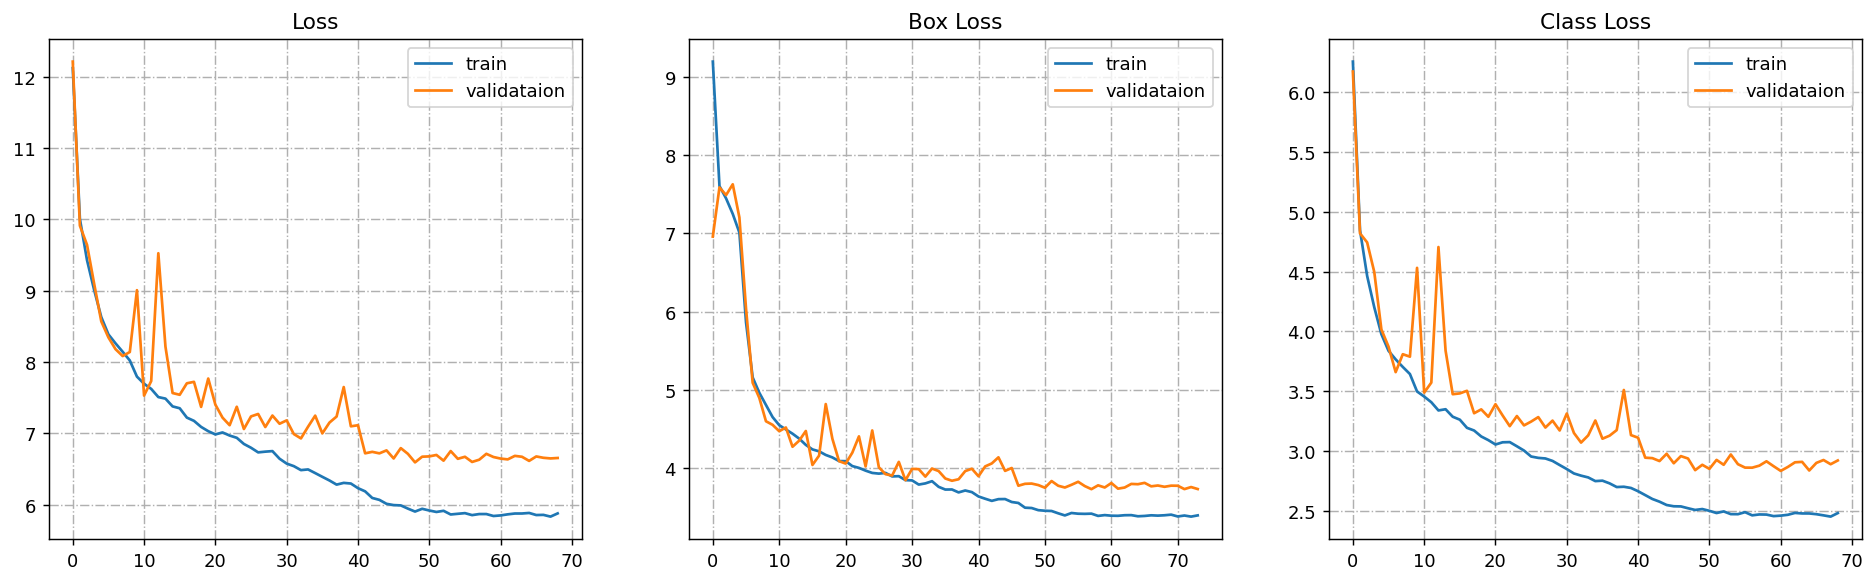

In [ ]:
# Cell 14: Plotting Training History

# Plot the training history to visualize the loss and metrics over epochs.
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][5:])
axs[0].plot(hist.history['val_loss'][5:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][5:])
axs[2].plot(hist.history['val_class_loss'][5:])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
# Cell 15: Evaluating the Model

# Evaluate the trained model on the test dataset.
YOLOV8_model.evaluate(test_dataset)

3/3 [==============================] - 2s 95ms/step - loss: 6.8224 - box_loss: 4.0126 - class_loss: 2.8099


[6.822446346282959, 4.012588977813721, 2.809857130050659]

## Prediction and Visualization Stage

This section involves making predictions using the trained model and visualizing the results:

1. **Prediction:** The `predict` method of the trained model is used to generate predictions on the input data.

2. **Visualization:** The `keras_cv.visualization.plot_bounding_box_gallery` function is used to visualize the predicted bounding boxes along with the ground truth boxes.

This stage showcases the model's performance by visually displaying its predictions on the provided dataset.

In [ ]:
# Cell 16: Function to Visualize Predictions

# Define a function to visualize the predicted detections.
def visualize_predict_detections(model, dataset, bounding_box_format):
    """
    Visualizes the predicted detections on a dataset.

    Args:
        model (tf.keras.Model): The trained model.
        dataset (tf.data.Dataset): The dataset to visualize predictions on.
        bounding_box_format (str): The format of the bounding boxes.
    """
    images, y_true = next(iter(dataset.take(1))) # Get the first batch of data.

    y_pred = model.predict(images, verbose = 0) # Get the model's predictions.
    y_pred = keras_cv.bounding_box.to_ragged(y_pred) # Convert predictions to ragged tensors.
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images, # Images to visualize.
        value_range=(0, 255), # Value range of the images.
        bounding_box_format=bounding_box_format, # Format of the bounding boxes.
        y_true=y_true, # Ground truth bounding boxes.
        y_pred=y_pred, # Predicted bounding boxes.
        true_color = (192, 57, 43), # Color for the ground truth bounding boxes.
        pred_color=(255, 235, 59), # Color for the predicted bounding boxes.
        scale = 8, # Scale factor for the visualization.
        font_scale = 0.8, # Font scale for the labels.
        line_thickness=2, # Line thickness for the bounding boxes.
        dpi = 100, # DPI for the visualization.
        rows=2, # Number of rows in the grid.
        cols=2, # Number of columns in the grid.
        show=True, # Whether to show the visualization.
        class_mapping=class_mapping, # Mapping of class IDs to class names.
    )

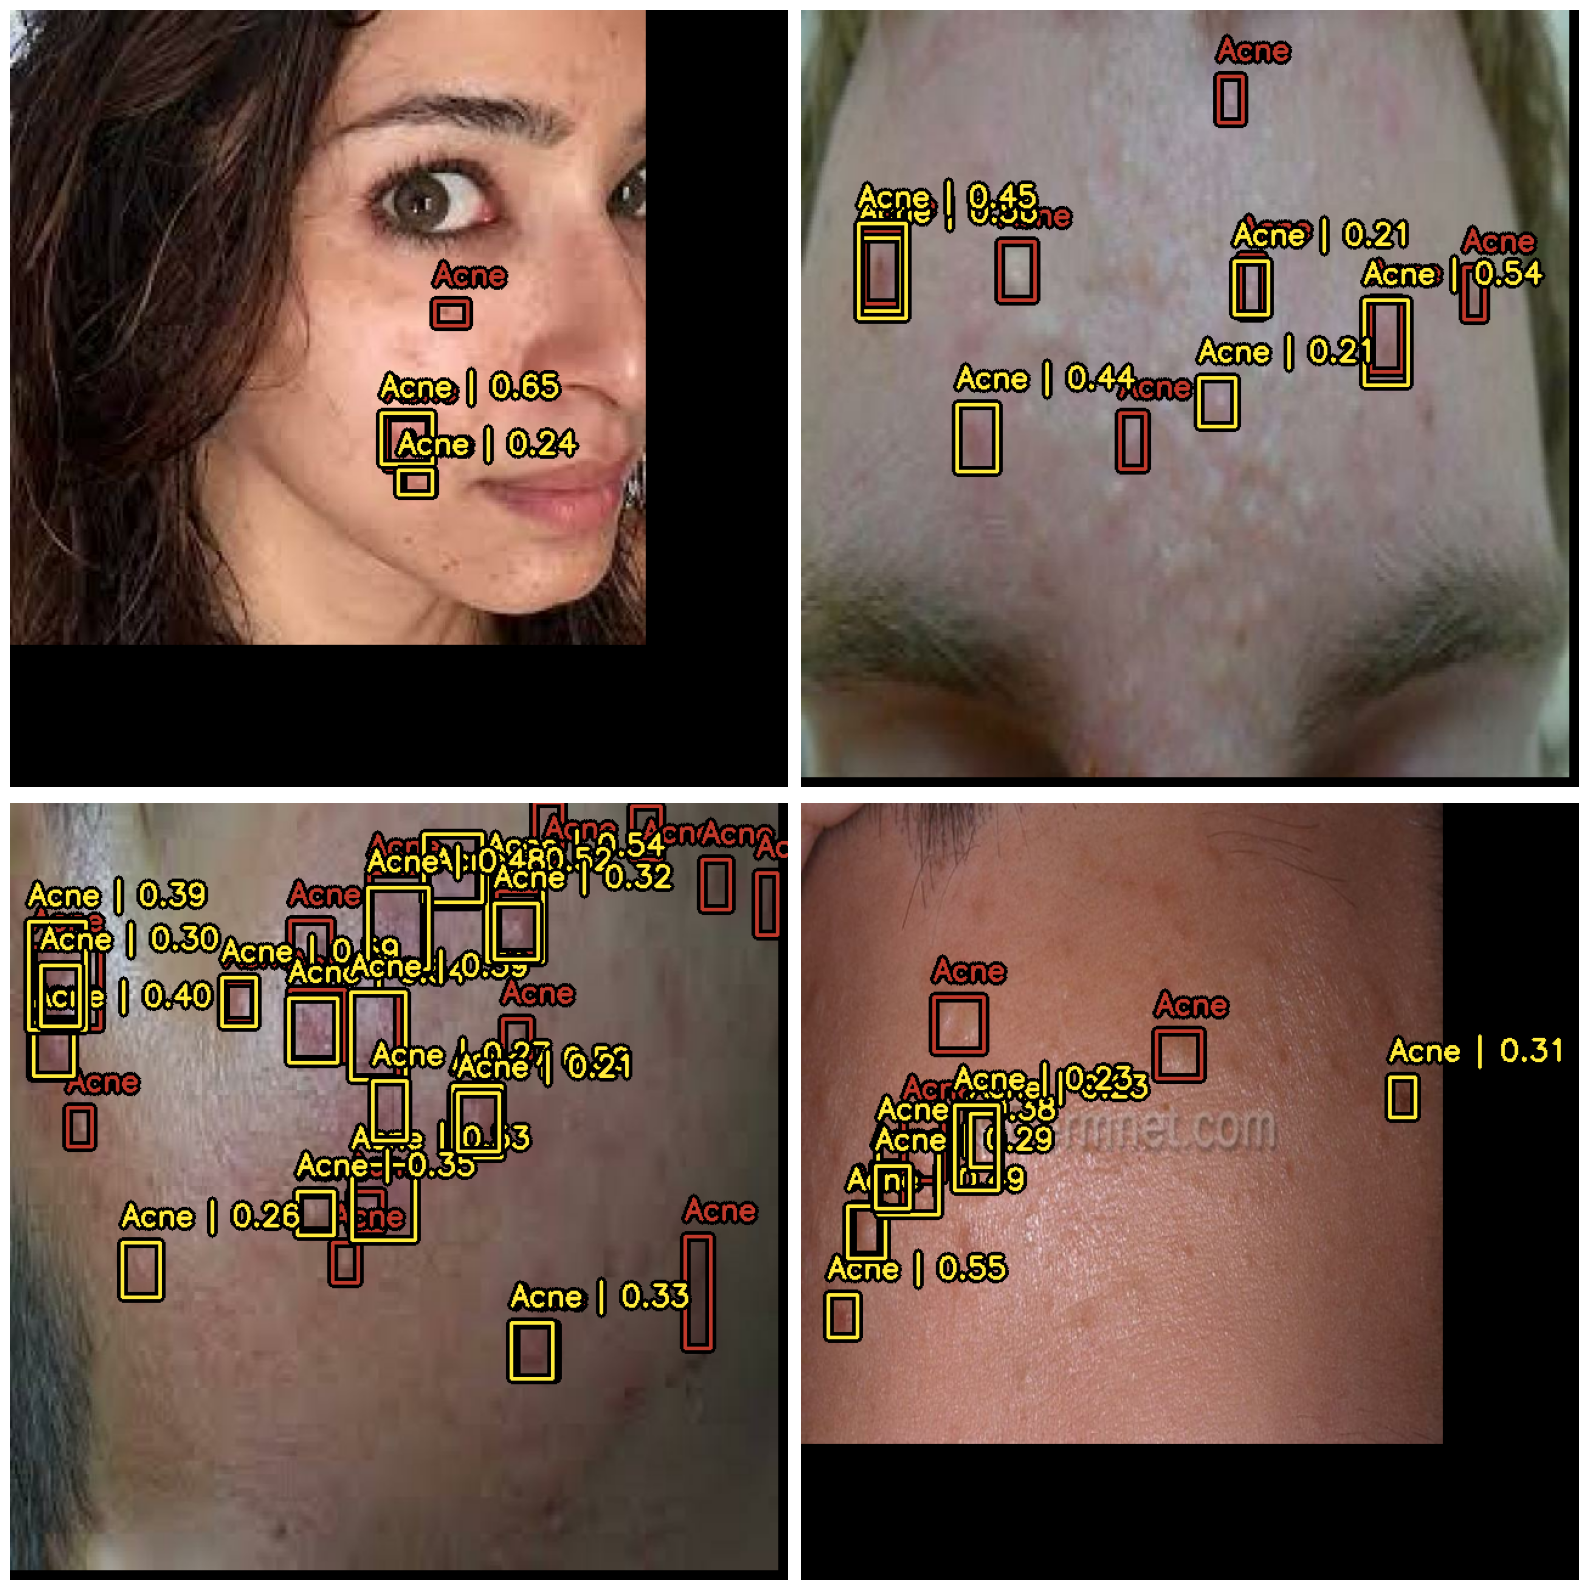

In [15]:
# red -> ground true
# yellow -> prediction

YOLOV8_model.load_weights('/kaggle/working/yolo_acne_detection.h5')
visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")